In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import re
import collections
import random

In [2]:
#读取
def read_time_machine():  
    """Load the time machine dataset into a list of text lines."""
    with open('../data/timemachine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
    # strip(): 去掉每一行开头和结尾的空白字符 
lines = read_time_machine()

In [3]:
#token化
def tokenize(lines,token='char'):
    if token=='word':
        return [line.split() for line in lines]
    elif token=='char':
        return [list(line) for line in lines]
    else:
        print('未知错误'+token)

tokens=tokenize(lines)

In [4]:
class Vocab:#处理词的
    def __init__(self,tokens=None,min_freq=0,reserved_token=None):
        if tokens is None:
            tokens=[]
        if reserved_token is None:
            reserved_token=[]
        counter=counter_corpus(tokens)
        self.token_freq=sorted(counter.items(),key= lambda x:x[1],reverse=True)
        self.unk,uniq_tokens=0,['unk']+reserved_token
        uniq_tokens+=[
            token for token,freq in self.token_freq
            if freq>=min_freq and token not in uniq_tokens
        ]
        self.idx_to_token,self.token_to_idx=[],dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token]=len(self.idx_to_token)-1
            
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self,tokens):
        if not isinstance(tokens,(tuple,list)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_token(self,indices):
        if not isinstance(indices,(tuple,list)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[indice] for indice in indices]

def counter_corpus(tokens):
    if isinstance(tokens[0],list):
        tokens=[token for line in tokens for token in line]
    return collections.Counter(tokens)

In [5]:
vocab = Vocab(tokens)


In [6]:
def load_corpus_machine_times(max_tokens=-1):#获取corpus
    lines=read_time_machine()
    tokens=tokenize(lines)
    vocab=Vocab(tokens)
    corpus=[vocab[token] for line in tokens for token in line]
    if max_tokens>0:
        corpus=corpus[:max_tokens]
    return corpus,vocab

In [7]:
def seq_data_iter_random(corpus,batch_size,num_steps):
    corpus=corpus[random.randint(0,num_steps-1):]
    num_sub=(len(corpus)-1)//num_steps  #'//'是向下取整
    initial_indices=list(range(0,num_steps*num_sub,num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos+num_steps]
    num_batches=num_sub//batch_size
    for i in range(0,batch_size*num_batches,batch_size):
        initial_indices_per_batch=initial_indices[i:i+batch_size]
        #print(num_batches)
        #print(i+batch_size)
        #print(initial_indices)
        #print(initial_indices_per_batch)
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [8]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  
    """使用顺序分区生成一个小批量子序列。"""
    offset = random.randint(0, num_steps-1)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [9]:
class SeqDataLoader:  
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_machine_times(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [10]:
def load_data_time_machine(batch_size, num_steps,  
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

In [11]:
batch_size,num_steps=32,35
train_iter,vocab=load_data_time_machine(batch_size,num_steps)

In [12]:
#设置参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs=num_outputs=vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    W_hq=normal((num_hiddens,num_outputs))
    b_h=torch.zeros(num_hiddens,device=device)
    b_q=torch.zeros(num_outputs,device=device)
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [13]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [14]:
def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q=params
    H,=state
    outputs=[]
    for X in inputs:
        H=torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y=torch.mm(H,W_hq)+b_q
        outputs.append(Y)
    #print(outputs)
    return torch.cat(outputs,dim=0),(H,)
    

In [26]:
class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens=vocab_size,num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn=init_state,forward_fn
    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [29]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_rnn_state, rnn)

In [30]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]#找到第一个词的索引
    print(outputs)
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:#把原本的拿到
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 5, net, vocab, d2l.try_gpu())

[3]


'time traveller  xxxx'

In [31]:
def grad_clipping(net, theta):  
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [32]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [33]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [34]:
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

In [35]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

困惑度 1.0, 112001.1 标记/秒 cuda:0
[3]
time travelleryou can show black is white by argument said filby
[3]
travelleryou can show black is white by argument said filby


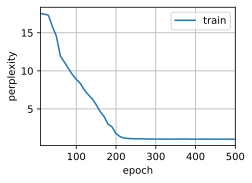

In [36]:
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr, num_epochs, device)